### HW recap and setup

You are going to train ridge regression using SGD.
Ridge regression has the cost function = MSE + alpha*||w||^2, where ||w|| is the Euclidean norm.
The goal is to find two optimal hyperparameters 1) learning rate of SGD and 2) alpha.

First, generate data like this:

`np.random.seed(0)`
`m = 100`
`X = 6 * np.random.rand(m, 1) - 3`
`y = 2 + X + 0.3 * X**2 + 2*np.random.randn(m, 1)`
`y = y.reshape((m))`

Use the seed 0.

1. Randomly split the data into 80% training data and 20% testing data. Then split the training data again into 75% training data and 25% validation data. Keep this split fixed.

2. Use SGDRegressor(max_iter=1000, tol=-np.infty, warm_start=True, penalty="l2", learning_rate="constant", random_state=0, alpha=alpha, eta0=eta0)
What does this do? Comment on the choice of arguments above.
Here alpha and eta0 are the value you are going to provide as the regularization weight and the learning rate.

3. For each combinations of alphas = [1E-6,1E-5,1E-4,1E-3,1E-2,1E-1], eta0s = [1E-6,1E-5,1E-4,1E-3,1E-2,1E-1] 

(a) instantiate SGDRegressor,
(b) call fit(),
(c) call predict() and measure training and validation scores.

4. Report the training and validation error for each combination. Which combination has the smallest validation error?

5. Now use these hyperparameters to retrain the model from scratch using ALL training data (=train + validation sets).Plot the training and test error as a function of epochs. You might want to use SGDRegressor(max_iter=1, ... )

6. Report the test score or this final model, and also plot the test data vs final linear regression as a line.

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

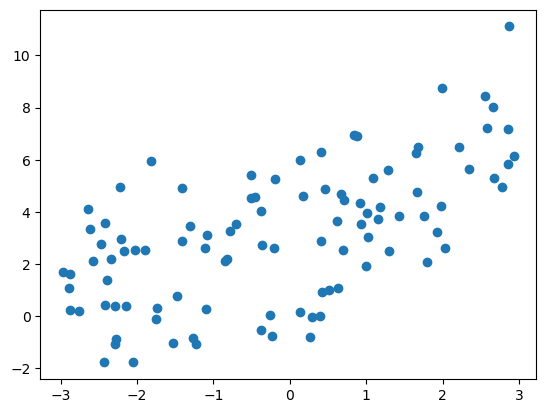

In [2]:
np.random.seed(0)
m = 100
X = 6 * np.random.rand(m) - 3
Y = 2 + X + 0.3 * X**2 + 2*np.random.randn(m)
plt.scatter(X,Y)


### 1. Randomly split the data into 80% training data and 20% testing data. Then split the training data again into 75% training data and 25% validation data. Keep this split fixed.

Let's split the data using some random indices, to make thing easier for me I'll use pandas.

,x,y
0,0.292881,-0.011685
1,1.291136,5.592899
2,0.616580,3.661956
3,0.269299,-0.781432
4,-0.458071,4.581382
...,...,...
95,-1.900852,2.546309
96,0.519078,0.993091
97,-2.879355,0.228751
98,1.973640,4.231152


<AxesSubplot:xlabel='x', ylabel='y'>

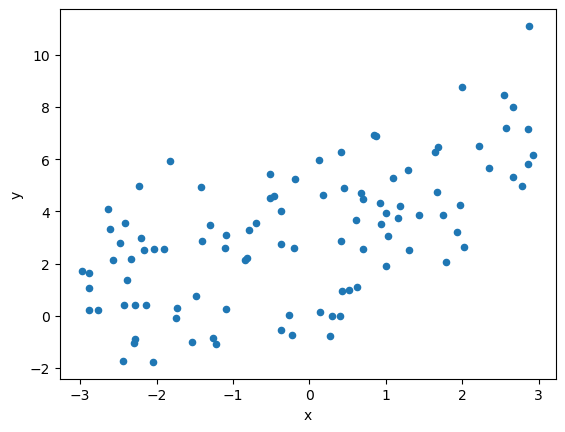

In [3]:
import pandas as pd

df = pd.DataFrame()
df["x"]=X
df["y"]=Y
display(df)
df.plot.scatter(x="x",y="y")


In [4]:
np.random.seed(0)

# create a random index permutation
ind =np.array(range(0,m))
ind = np.random.permutation(ind)

# keeping the last 20% for testing
split = int(m*0.8)
test_ind = ind[split:m]
test = df.iloc[test_ind]
test.info()
print("\n")
# and now further break into 75% train and 25% validation 
t_split = int((split+1)*0.75)

train_ind = ind[0:t_split]
train = df.iloc[train_ind]
train.info()
print("\n")

valid_ind = ind[t_split:split]
valid = df.iloc[valid_ind]
valid.info()
print("\n")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 25 to 44
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       20 non-null     float64
 1   y       20 non-null     float64
dtypes: float64(2)
memory usage: 480.0 bytes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 26 to 52
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       60 non-null     float64
 1   y       60 non-null     float64
dtypes: float64(2)
memory usage: 1.4 KB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 10 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       20 non-null     float64
 1   y       20 non-null     float64
dtypes: float64(2)
memory usage: 480.0 bytes




### 2. Use SGDRegressor(...) What does this do? Comment on the choice of arguments above. Here alpha and eta0 are the value you are going to provide as the regularization weight and the learning rate.

According to the documentation in the [scikit-learn page](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) and the wiki page of SGD the parameters are:

- `max iter` is the max number of iterations if the tolerance is not archieved, in this case 1000.
- `tol` is the stopping tolerance, i.e. a condition to stop if the cost function doesn't change too much in the last $n$ iterations. Making it infinity makes sure we never stop until we do the 1000 iterations.
- `warm_start` reuses the last call fit solution to initialize, so it has already "warm up" training.
- `penalty` the cost function regularization term, in this case is the $l^2$ norm, so the sum of the squares of the regression coefficients
- `learning rate` is the lenght of the step of the gradient descent, in this case constant and equal to `eta0`
- `random_state` random seed used for pseudo random stuff like shuffling the data
- `alpha` coefficient of the regularization term added to the cost function, I will vary this to see the effects
- `eta0` in general parameter involved on the step size calculation. In this particular case is constant so the step size is exactly `eta0`. I will vary this to see the effects.

### 3. For each combinations of alphas, eta0s (a) instantiate SGDRegressor, (b) call fit(), (c) call predict() and measure training and validation scores.

In [7]:
from sklearn.linear_model import SGDRegressor

alphas = [1E-6,1E-5,1E-4,1E-3,1E-2,1E-1]
eta0s = [1E-6,1E-5,1E-4,1E-3,1E-2,1E-1]

for alpha in alphas:
    for eta0 in eta0s:
        print(alpha, eta0)
        
"""SGD = SGDRegressor(
    max_iter=1000, 
    tol=-np.infty, 
    warm_start=True,
    penalty="l2", 
    learning_rate="constant", 
    random_state=0, 
    alpha=alpha, 
    eta0=eta0)"""

1e-06 1e-06
1e-06 1e-05
1e-06 0.0001
1e-06 0.001
1e-06 0.01
1e-06 0.1
1e-05 1e-06
1e-05 1e-05
1e-05 0.0001
1e-05 0.001
1e-05 0.01
1e-05 0.1
0.0001 1e-06
0.0001 1e-05
0.0001 0.0001
0.0001 0.001
0.0001 0.01
0.0001 0.1
0.001 1e-06
0.001 1e-05
0.001 0.0001
0.001 0.001
0.001 0.01
0.001 0.1
0.01 1e-06
0.01 1e-05
0.01 0.0001
0.01 0.001
0.01 0.01
0.01 0.1
0.1 1e-06
0.1 1e-05
0.1 0.0001
0.1 0.001
0.1 0.01
0.1 0.1


'SGD = SGDRegressor(\n    max_iter=1000, \n    tol=-np.infty, \n    warm_start=True,\n    penalty="l2", \n    learning_rate="constant", \n    random_state=0, \n    alpha=alpha, \n    eta0=eta0)'